In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr, spearmanr, entropy, rankdata
from sklearn.manifold import MDS
from scipy.ndimage import gaussian_filter1d

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [2]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [81]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, 100:400, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        # spearman instead of correlation
        Xrdv = np.apply_along_axis(rankdata, 1, Xrdv)
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

def static_rdm(dat, roi, mode='top', scale=30, tstart=100, tend=400, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {roi}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    # score images (using global RESP/BASE you already defined)
    scores = np.nanmean(X[:, RESP, :], axis=(0, 1)) - np.nanmean(X[:, BASE, :], axis=(0, 1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # pick image subset
    idx = order[:scale]

    # restrict to desired time window
    Ximg = X[:, tstart:tend, idx]                    # (units, time, images)

    # time-by-RDV (one RDV per timepoint)
    Xrdv = np.array([
        pdist(Ximg[:, t, :].T, metric='correlation')
        for t in range(Ximg.shape[1])
    ])  # (time, n_pairs)

    # # Spearman: rank-transform rows, then use correlation distance across time
    Xrank = np.apply_along_axis(rankdata, 1, Xrdv)
    R = squareform(pdist(Xrank, metric=metric))      # (time, time)

    return R, Xrdv

def rdv(X):
    ind = np.triu_indices_from(X, k=1)
    return(X[ind])

def l2(X):
    return np.sqrt(np.sum((X)**2))

def ED1(R):
    S = -0.5 * R**2
    lam = np.linalg.eigvalsh(S)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()

def ED2(R):
    # R = distance matrix
    n = R.shape[0]
    J = np.eye(n) - np.ones((n, n))/n
    B = -0.5 * J @ (R**2) @ J
    lam = np.linalg.eigvalsh(B)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()


def entropy(V):
    v = np.abs(V)
    return v / v.sum()

In [89]:
SCALES = {
    'MF1_8_F': 25,
    'Unknown_19_F': 30,
    'MF1_7_F': 60,
    'MF1_9_F': 45,
}
    
ROI = 'Unknown_19_F' # Unknown_19_F, 
MODE = 'top'
scale = SCALES[ROI]
t0 = 100
window = 200

Rt, _ = static_rdm(dat, ROI, mode=MODE, scale=scale,
                  tstart=t0, tend=t0 + window)

Ra, _ = static_rdm(dat, ROI, mode=MODE, scale=1072,
                  tstart=t0, tend=t0 + window)

Rs, _ = static_rdm(dat, ROI, mode='shuff', scale=scale,
                  tstart=t0, tend=t0 + window)

Text(0.5, 1.0, 'Global Span')

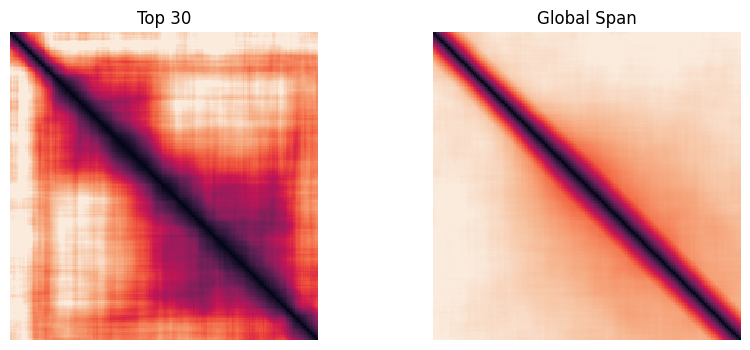

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

ax = axes[0]
sns.heatmap(Rt, vmax=1, 
            cbar=False, square=True, 
            ax=ax)
ax.set_axis_off()
ax.set_title(f'Top {scale}')

ax = axes[1]
sns.heatmap(Ra, vmax=1, 
            cbar=False, square=True, 
            ax=ax)
ax.set_axis_off()
ax.set_title('Global Span')

[np.float64(4.095948694679624), np.float64(9.089491840358898), np.float64(8.306951400142749)]


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_4400/2021554748.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(vals, palette=['Red', 'Blue', 'Gray'], ax=ax)
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_4400/2021554748.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'T{scale}', 'S30', 'All'])


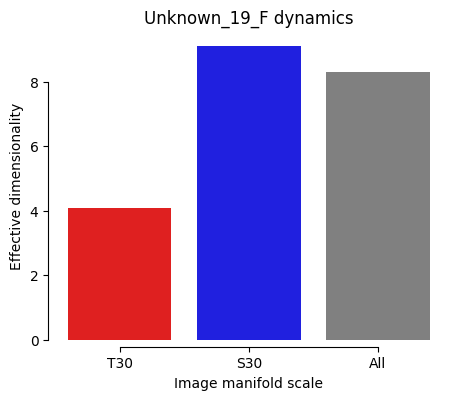

In [93]:
Vt = rdv(Rt); Va = rdv(Ra)

vals = [ED2(Rt), ED2(Rs), ED2(Ra)]
print(vals)

fig,ax = plt.subplots(1,1, figsize=(5,4))
sns.barplot(vals, palette=['Red', 'Blue', 'Gray'], ax=ax)

ax.set_title(f'{ROI} dynamics')
ax.set_xlabel('Image manifold scale')
ax.set_ylabel('Effective dimensionality')
ax.set_xticklabels([f'T{scale}', 'S30', 'All'])

sns.despine(fig, trim=True, offset=5)